## Visualizing the Convolutional Layers
In this notebook we will visualize the images after the convolutional layers and try to identify the features within the image that explains the model's classification.

In [34]:
import os
import sys
sys.path.append("../")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import multilabel_confusion_matrix, classification_report, accuracy_score, f1_score

from src.utilities import (
    load_dataset, 
    targ_shape,
    dataset_name,
    test_dataset_name,
    opt,
    base_dir, train_dir, test_dir,
    fbeta,
    create_file_mapping,
    create_tag_map,
    test_fnames
)

### 1.0 Imports

In [2]:
model_name = 'cnn_%s_SGD.h5'%(targ_shape[0])

In [41]:
# Load the file with the images names and labels
mapping_csv = pd.read_csv(base_dir + '/train_classes.csv')

# Loading the compiling the previously trained model
cnn_model = load_model(base_dir+'/'+model_name, compile=False)
cnn_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
print(cnn_model)

# Loading the test dataset
X_test, y_test = load_dataset(test_dataset_name, False)

Shape of the original dataset: (4047, 64, 64, 3)


### 2.0 Making a prediction

In [42]:
# realizando a previsao da imagem nova
prediction = cnn_model.predict(X_test)
threshold = 0.5
binary_pred_labels = (prediction > threshold).astype(int)

127/127 [==============================] - 7s 51ms/step


In [43]:
print(f"Shape of predictions: {binary_pred_labels.shape}")

Shape of predictions: (4047, 17)


In [47]:
cm = classification_report(y_test, binary_pred_labels)
print(cm)

              precision    recall  f1-score   support

           0       0.29      0.00      0.00      1251
           1       0.03      0.29      0.06        35
           2       0.00      0.00      0.00       102
           3       0.00      0.00      0.00        27
           4       0.00      0.00      0.00        13
           5       0.85      0.89      0.87      2872
           6       0.24      0.86      0.37       199
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00       451
           9       0.10      0.87      0.18       346
          10       0.00      0.00      0.00       262
          11       0.55      0.12      0.20       714
          12       0.97      0.74      0.84      3758
          13       0.22      0.89      0.36       789
          14       0.00      0.00      0.00        28
          15       0.00      0.00      0.00        24
          16       0.26      0.45      0.33       716

   micro avg       0.48   

/home/michel/anaconda3/envs/cv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/michel/anaconda3/envs/cv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [46]:
# Compute accuracy
accuracy = accuracy_score(y_test, binary_pred_labels)

# Compute F1 score
f1 = f1_score(y_test, binary_pred_labels, average='weighted')  # Use 'micro', 'macro', or 'weighted' depending on your preference

print("Accuracy: {:.4f}".format(accuracy))
print("F1 Score: {:.4f}".format(f1))

Accuracy: 0.0497
F1 Score: 0.5566


In [140]:
# Loading the image-label dictionary
mapping = create_file_mapping(mapping_csv)

# Loading the label-number dictionary
labels_map, inv_labels_map = create_tag_map(mapping_csv)

# Loading the testset
Xte, yte = load_dataset(test_dataset_name, training=False)

# Creating a list with all possible labels
classes = []
for i in range(len(inv_labels_map)):
    classes.append(inv_labels_map[i])

# Defning the tresholds
threshold = 0.3

# Loading the test image
img_name = imagefile
print(f"Figure name: {img_name}")
img = load_img(test_dir + '/' + img_name, target_size=targ_size)
img_original_size = load_img(test_dir + '/' + img_name)
imgarray = img_to_array(img)
print(imgarray.shape)
imgarray = imgarray.reshape((1,) + imgarray.shape)  # Alterando a dimensão, agora é um vetor unidimensional
imgarray = imgarray / 255
print(imgarray.shape)

# realizando a previsao da imagem nova
prediction = cnn_model.predict(imgarray)

# Criando uma lista com as classes verdadeiras da referida imagem
true_classes = mapping[imagefile.split('.')[0]]

# Criando uma lista ordenada com as classes verdadeiras e todas as outras classes
true_classes_list =[0 for i in range(len(classes))]
for class_ in true_classes:
    index_ = classes.index(class_)
    true_classes_list[index_] = 1

# Criando um dataframe para organizar todas as informações da classificacao da imagem
df_labels = pd.DataFrame(classes, columns=['Labels'])
df_labels['True_labels'] = pd.Series(true_classes_list)
df_labels['Predicted_proba'] = pd.Series(prediction[0])

# Definindo como 1 as classes que possuem probabilidade maior que % e 0 o contrario
def enconder(probabilidade):
    if probabilidade>threshold:
        return 1
    else:
        return 0
df_labels['Predicted_labels'] = df_labels['Predicted_proba'].apply(enconder)
print(df_labels)

TP = len(df_labels[(df_labels['True_labels'] == 1) & (df_labels['Predicted_labels'] == 1)])
FP = len(df_labels[(df_labels['True_labels'] == 0) & (df_labels['Predicted_labels'] == 1)])
TN = len(df_labels[(df_labels['True_labels'] == 0) & (df_labels['Predicted_labels'] == 0)])
FN = len(df_labels[(df_labels['True_labels'] == 1) & (df_labels['Predicted_labels'] == 0)])
print('True Positives: ',TP)
print('False Positives: ',FP)
print('True Negatives: ',TN)
print('False Negatives: ',FN)

# definindo e calculando as métricas
# Precision
precision = round(TP / (TP + FP), 3)
print('Avg Precision: ', precision)

# Recall (Sensibilidade ou True Positive Rate)
recall = round(TP / (TP + FN), 3)
print('Avg Recal: ', recall)

# F1 Score (Media ponderada entre precision e recall)
f1_score = round(2 * (precision * recall) / (precision + recall), 3)

# Overall Accuracy (Porcentagem de acertos sobre o total)
acc = round((TP+TN)/(TP + FP + TN + FN), 3)

print('Avg Accuracy: ', acc)
print('Avg F1_Score:', f1_score)
print('\n')
print('As classes previstas da imagem são: ')
print(df_labels[df_labels['Predicted_labels']==1]['Labels'])

Shape of the original dataset: (4047, 64, 64, 3)
Figure name: train_36629.jpg
(64, 64, 3)
(1, 64, 64, 3)
1/1 [==============================] - 0s 85ms/step
               Labels  True_labels  Predicted_proba  Predicted_labels
0         agriculture            1         0.500967                 1
1      artisinal_mine            0         0.027806                 0
2         bare_ground            0         0.038869                 0
3            blooming            0         0.000068                 0
4           blow_down            0         0.000033                 0
5               clear            1         0.995395                 1
6              cloudy            0         0.000001                 0
7   conventional_mine            0         0.001340                 0
8         cultivation            1         0.063578                 0
9          habitation            1         0.650406                 1
10               haze            0         0.004573                 0
11 

### 3.0 Viz the output

In [141]:
#Defining the outputs of all layers
layer_outputs = [layer.output for layer in cnn_model.layers]
activation_model = tf.keras.models.Model(inputs = cnn_model.input, outputs = layer_outputs)

#Taking the output images of all layers for first image of training set
activations = activation_model.predict(imgarray)

1/1 [==============================] - 1s 583ms/step


(1, 64, 64, 16)
(64, 64)
4


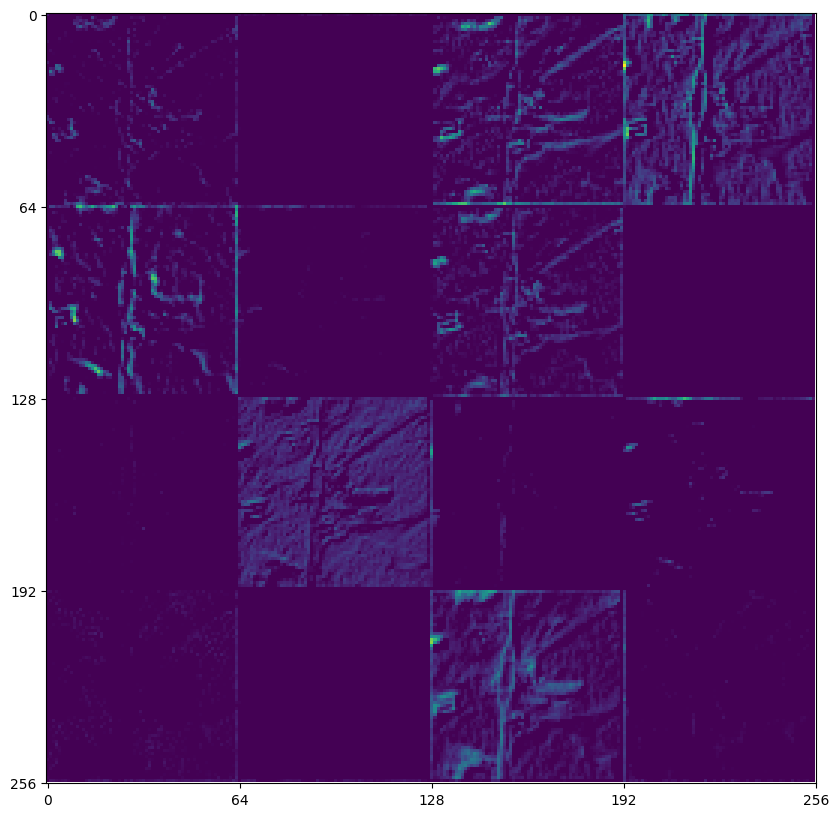

4


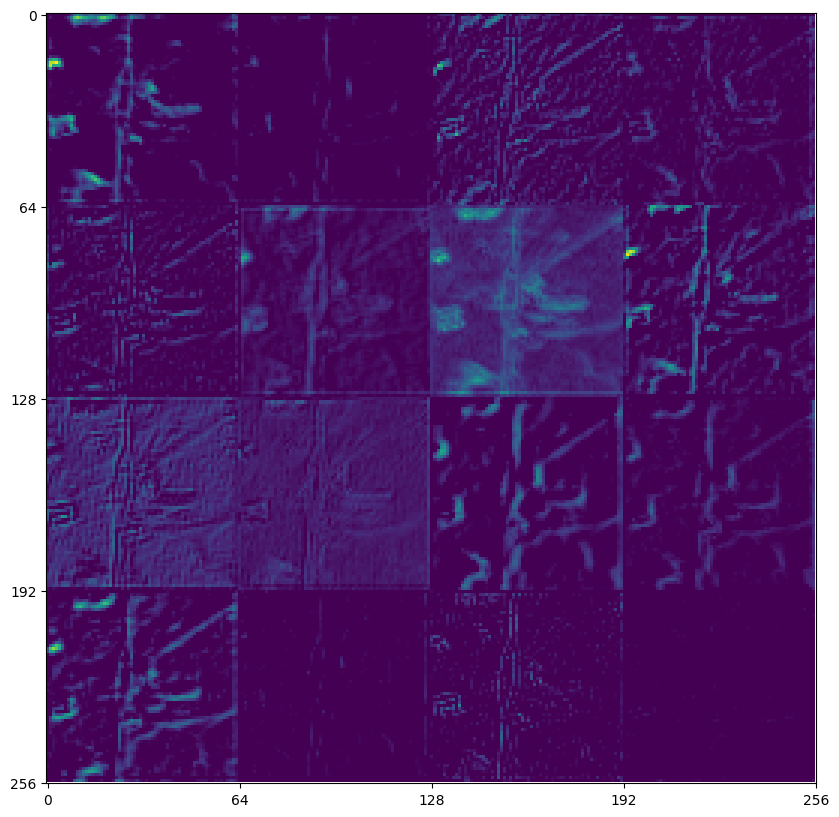

4


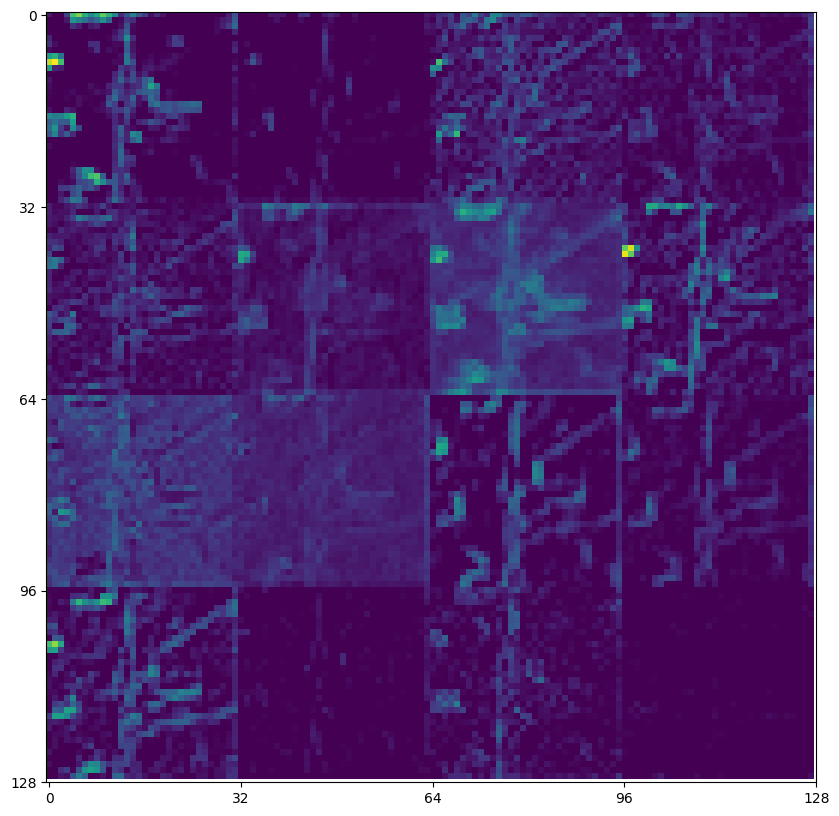

4


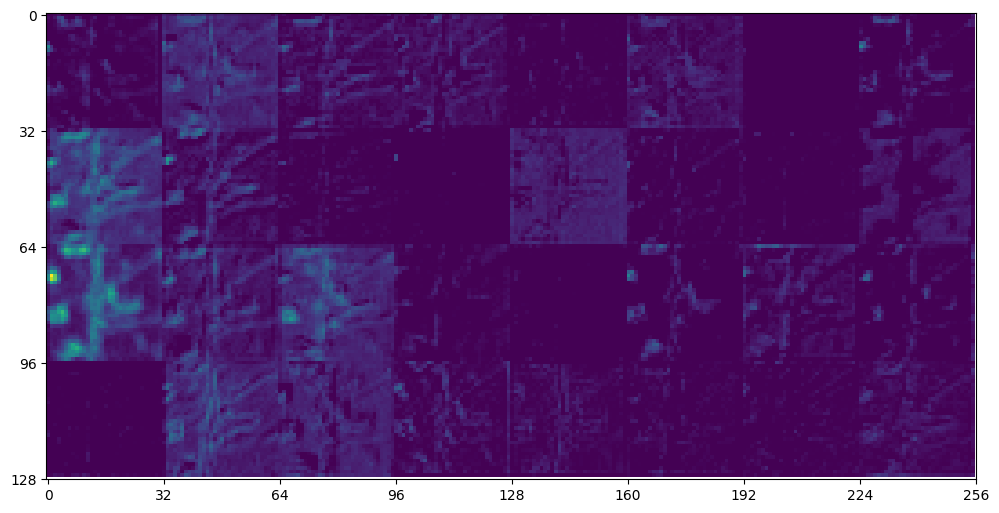

4


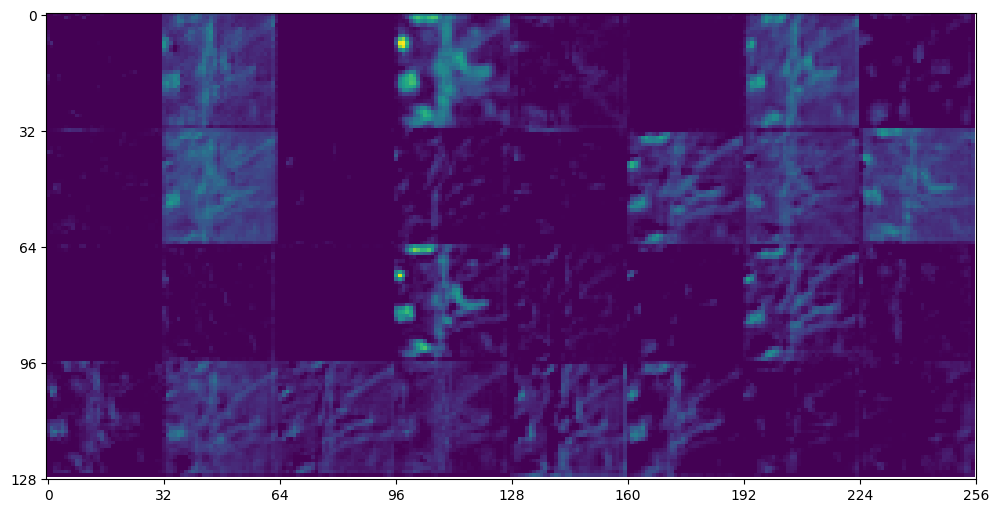

4


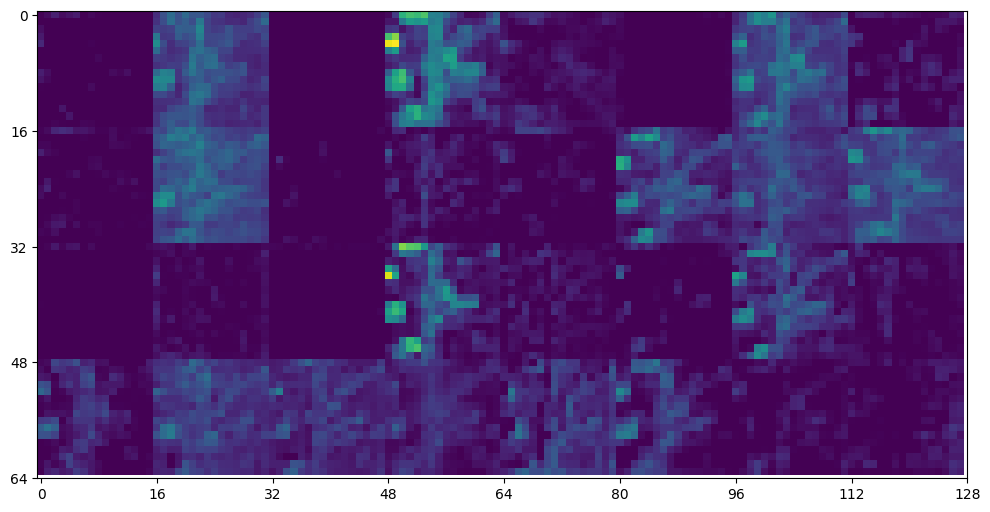

4


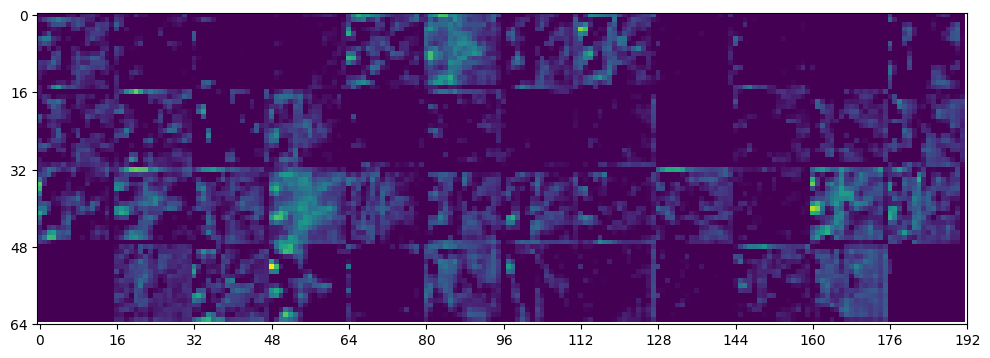

4


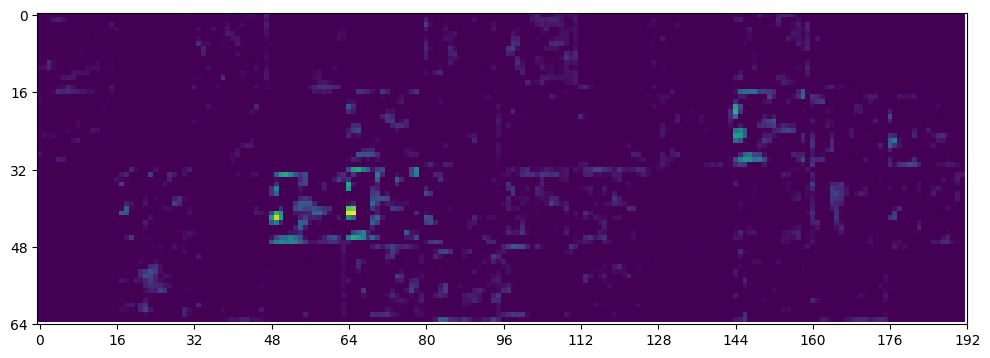

4


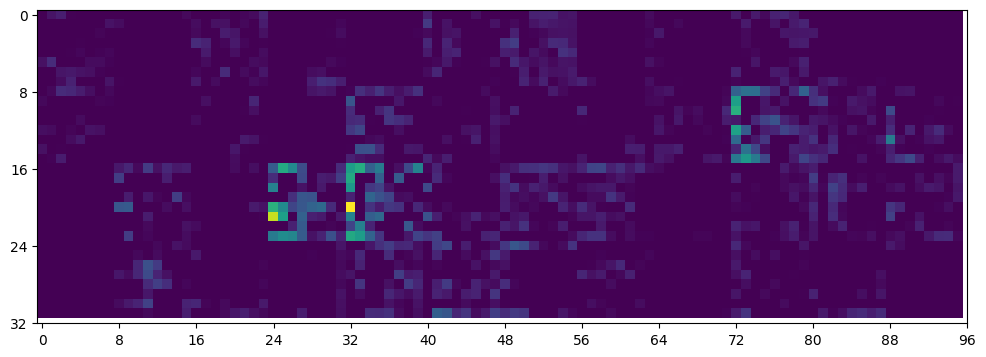

Final Layer


In [178]:
first_layer = activations[0]
print(first_layer.shape)
output = first_layer[0,:,:,0]
print(output.shape)

try:
    for layer in range(len(activations)):
        first_layer = activations[layer]
        seq = []
        first_layer_shape = first_layer.shape[-1]
        if first_layer_shape == 16:
            multiple = 4
        elif first_layer_shape == 32:
            multiple = 8
        else:
            multiple = 12
            
        for k in (0, multiple, multiple*2, multiple*3):
            seq.append(np.concatenate([first_layer[0,:,:,i] for i in range (k,k+multiple)], axis = 1))
        print(len(seq))
        stack = np.concatenate([seq[i] for i in range(0,4)], axis = 0)
        plt.figure(figsize=(12,10))
        plt.imshow(stack)
        plt.xticks([first_layer.shape[1]*i for i in range(multiple+1)])
        plt.yticks([first_layer.shape[1]*i for i in range(5)])
        plt.show()
except:
    print("Final Layer")